In [13]:
from virgo.cluster import VirgoCluster

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import torch
from gpytorch import kernels

# from sklearn.gaussian_process.kernels import RBF
# from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


%load_ext autoreload
%autoreload 2

%matplotlib notebook
# https://towardsdatascience.com/transform-data-to-high-dimensional-kernel-space-87d62b670e0f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
file_name = "/home/max/Software/virgo/data/data.txt"
virgo_cluster = VirgoCluster(file_name=file_name)
virgo_cluster.scale_data()
virgo_cluster.print_datastats()

Shape: (694764, 7)
Mean / Std: 442.512 / 2048.529
Min / Max: -7516.963 / 38340.406
Shape: (694764, 7)
Mean / Std: -0.000 / 1.000
Min / Max: -4.197 / 217.386


In [16]:
# only use spatial points for kernel
X = virgo_cluster.scaled_data
torch_subdata = torch.tensor(X[:, [0, 1, 2]])
covar_module = kernels.LinearKernel()
lazy_covar_matrix = covar_module(torch_subdata) 
z_vals = lazy_covar_matrix.diag().detach().numpy()

X = np.array([*X.T, z_vals]).T
print(X.shape, X.max(), X.min(), X.mean())

(694764, 8) 217.3859613425792 -4.197077780281158 0.2599302097116269


In [27]:
elbos = []
for i in range(5, 15):
    model = GaussianMixture(n_components=i)
    model.fit(X)
    elbos.append(model.lower_bound_)
    print(i, model.lower_bound_)
    
plt.plot(elbos)
plt.show()    

5 -3.4846674655855785
6 -3.353337151776375
7 -2.2304464678731346
8 -2.0137367333787934
9 -2.733100880436384
10 -1.3390282318200155
11 -1.8042686828986199


KeyboardInterrupt: 

In [20]:
# model = BayesianGaussianMixture(n_components=20)
model = GaussianMixture(n_components=12)
model.fit(X)
pred_y1 = model.predict(X)
print(f"ELBO {model.lower_bound_:0.6f}")

# w_arr = np.array(model.weight_concentration_)
# print((w_arr > 1.).sum())
values, counts = np.unique(pred_y1, return_counts=True)
values = list(values)
print(values, counts)

virgo_cluster.cluster = virgo_cluster.data
virgo_cluster.cluster_labels = pred_y1

ELBO -1.392096
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [ 40765 129169  36691  89600  11577  39427  46418  45648  35910  60882
  91859  66818]


<IPython.core.display.Javascript object>


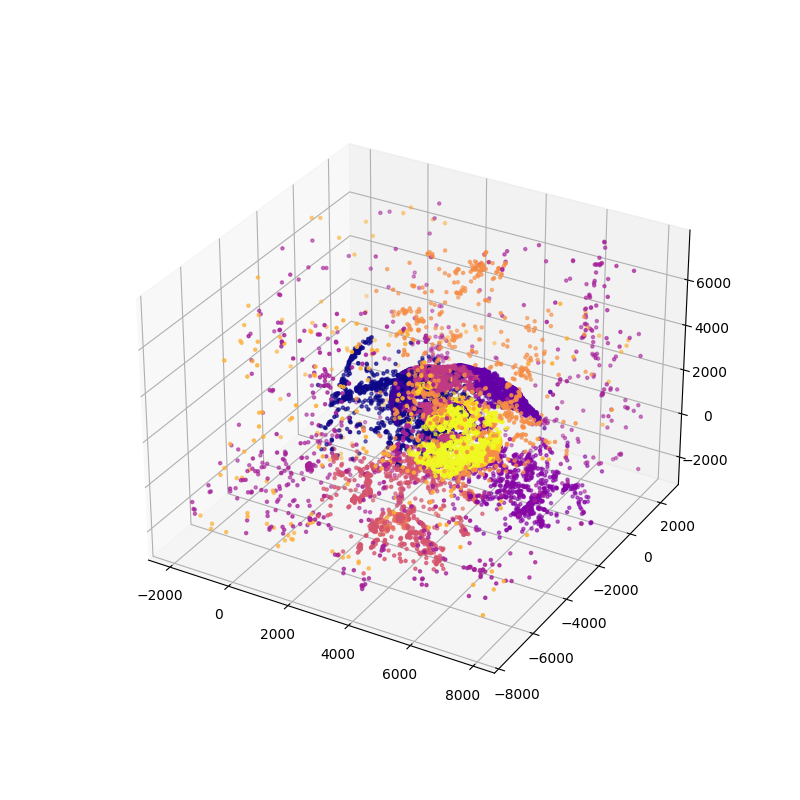

In [19]:
virgo_cluster.plot_cluster(n_step=50)

1.009232464395617 -30.33000155612 -30.052542527239495


<IPython.core.display.Javascript object>


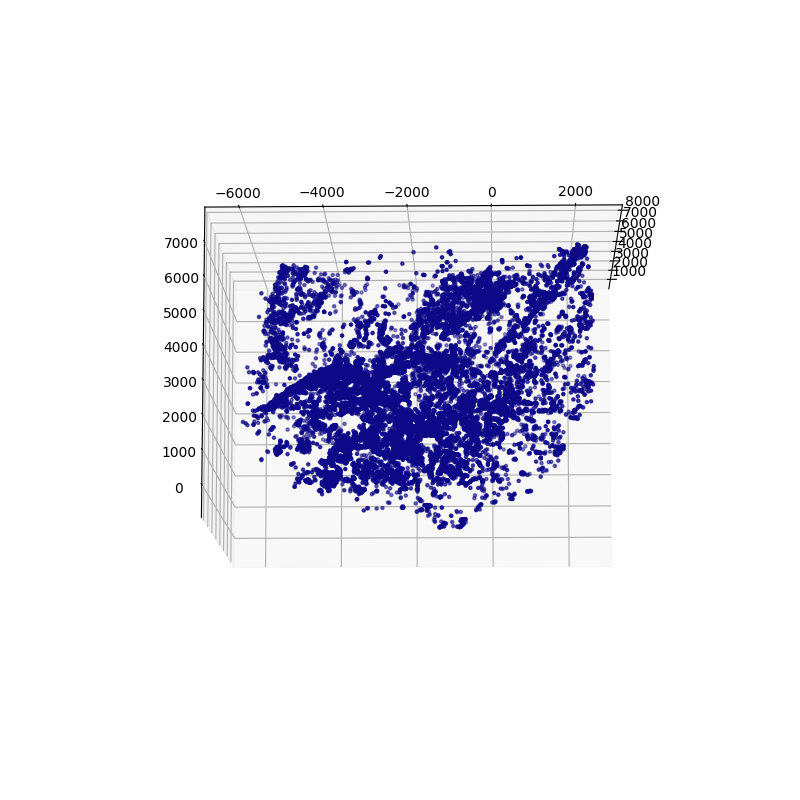

1.0510974654839431 -19.97067568147325 -18.99983240115455


<IPython.core.display.Javascript object>


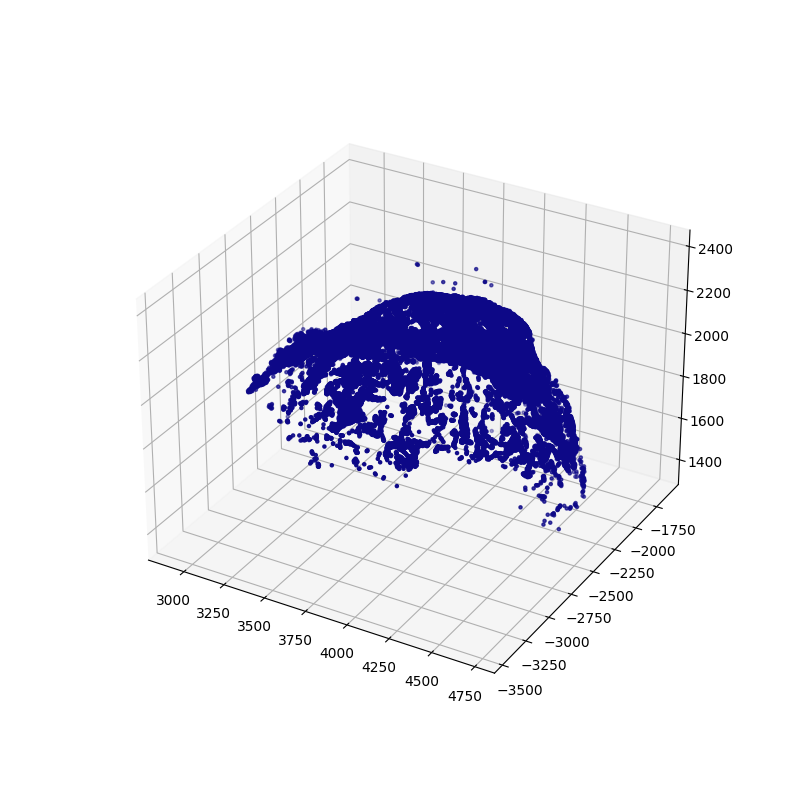

1.0287602087634664 -29.34870309538774 -28.52822537786901


<IPython.core.display.Javascript object>


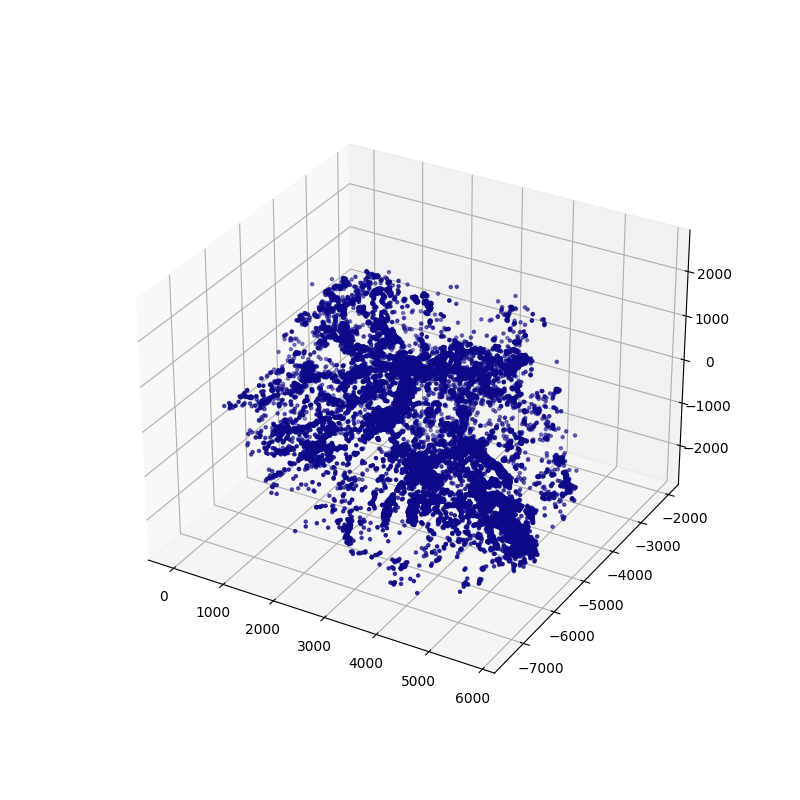

1.064229691608413 -25.647203278790165 -24.09931190702687


<IPython.core.display.Javascript object>


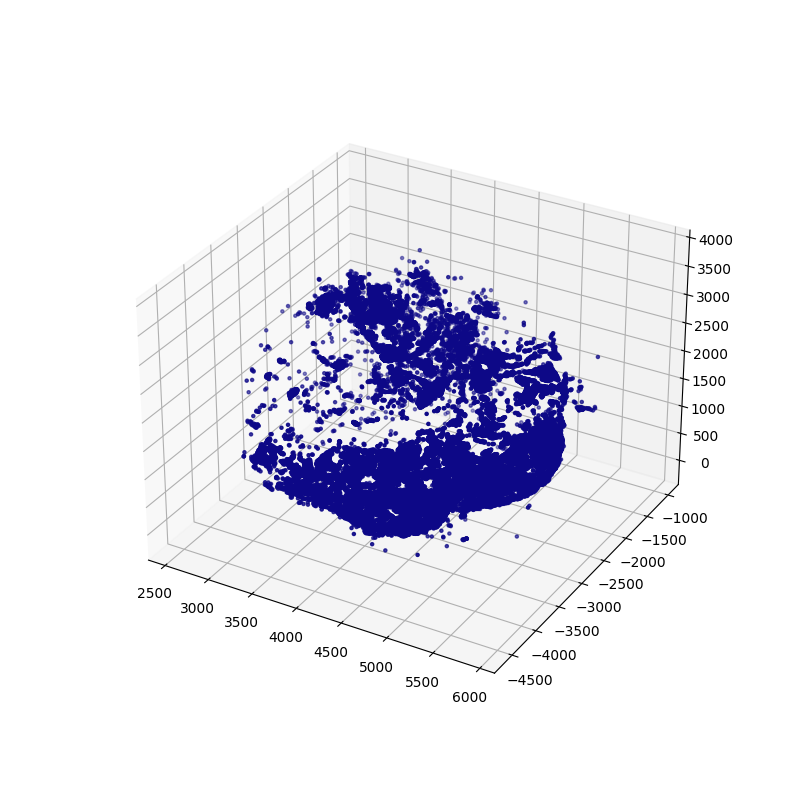

1.0164286333324326 -39.1953213337989 -38.56180360178785


<IPython.core.display.Javascript object>


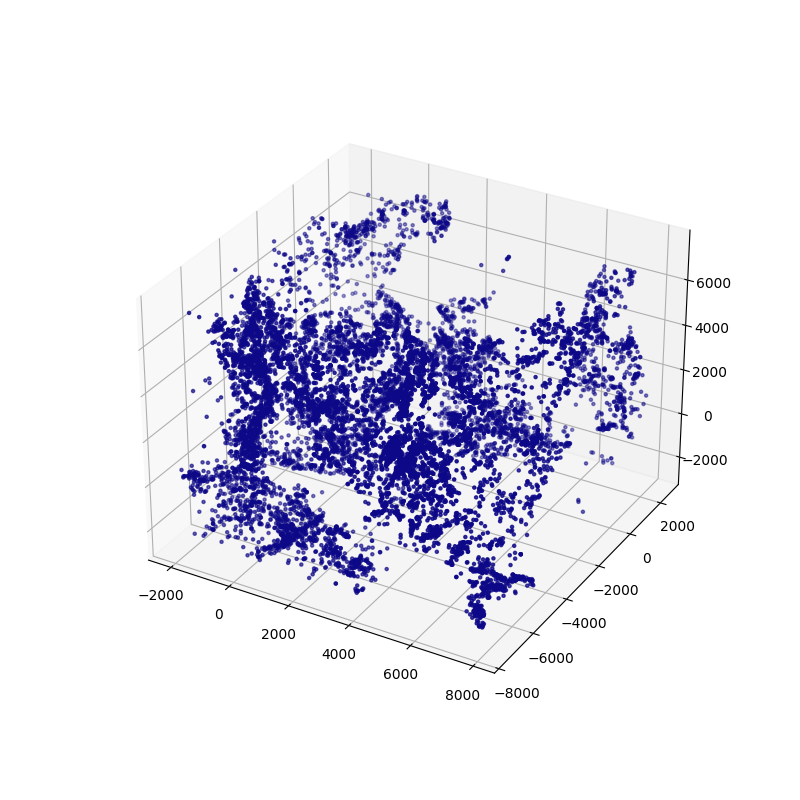

1.0081939891054716 -34.5308653509773 -34.2502194261395


<IPython.core.display.Javascript object>


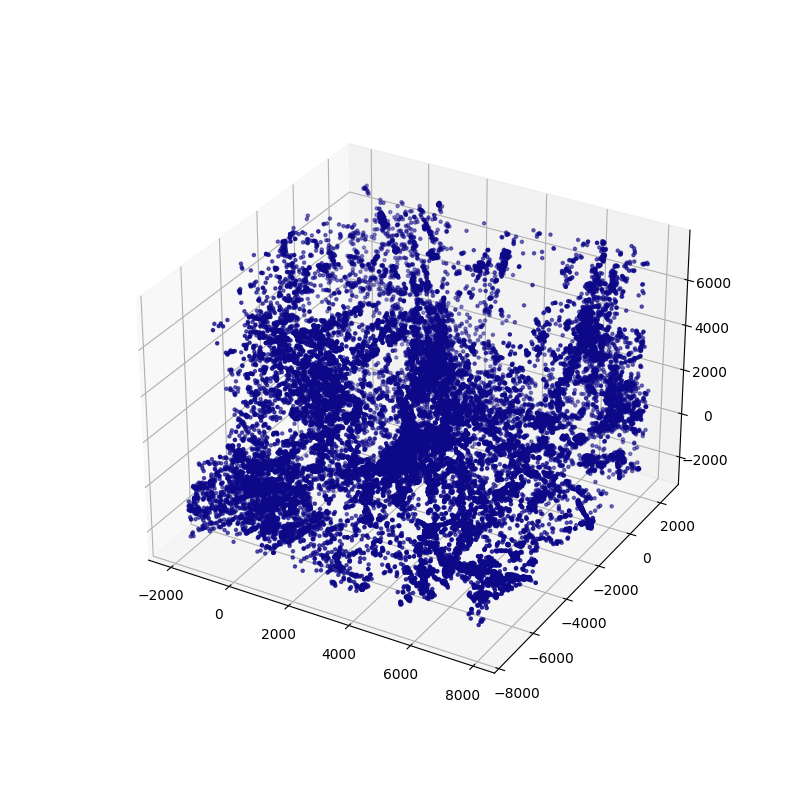

1.0311298284465633 -26.977665158788987 -26.163208952486492


<IPython.core.display.Javascript object>


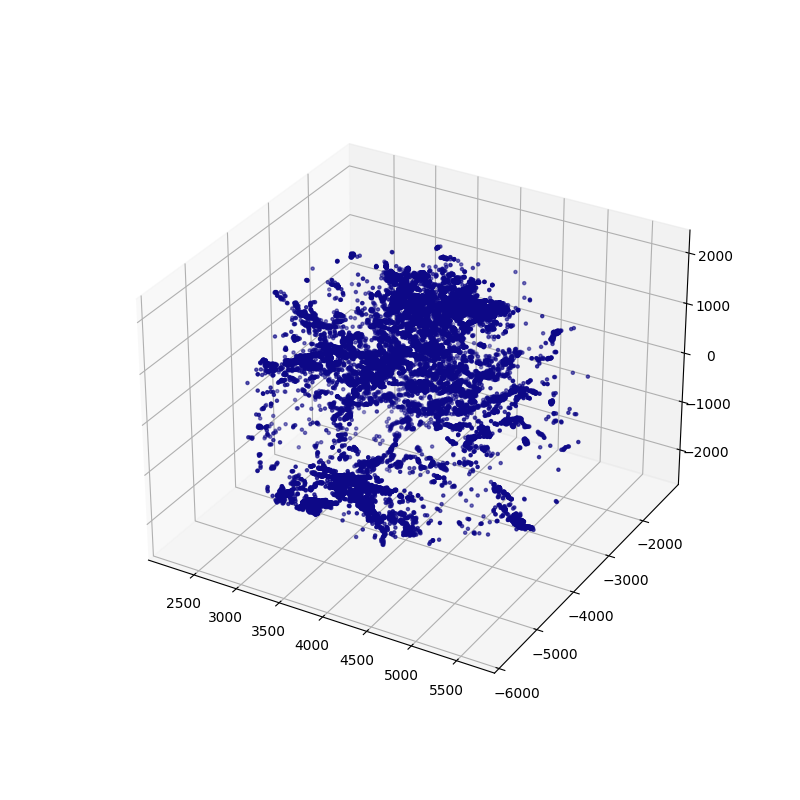

1.0160286222146444 -27.590560930650728 -27.155298903402343


<IPython.core.display.Javascript object>


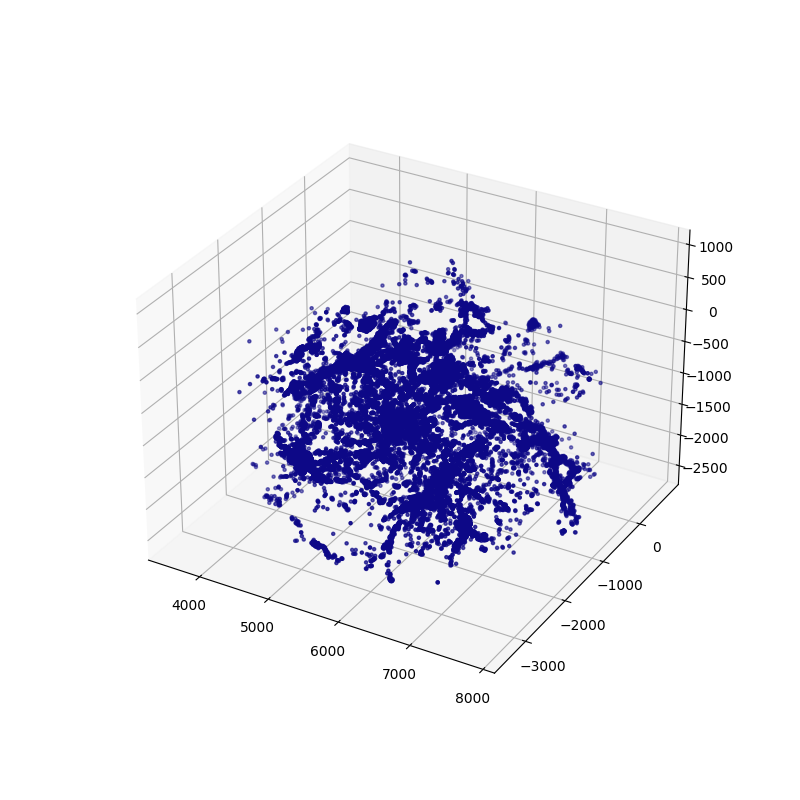

1.1030780672698604 -20.920318967295753 -18.965401985621877


<IPython.core.display.Javascript object>


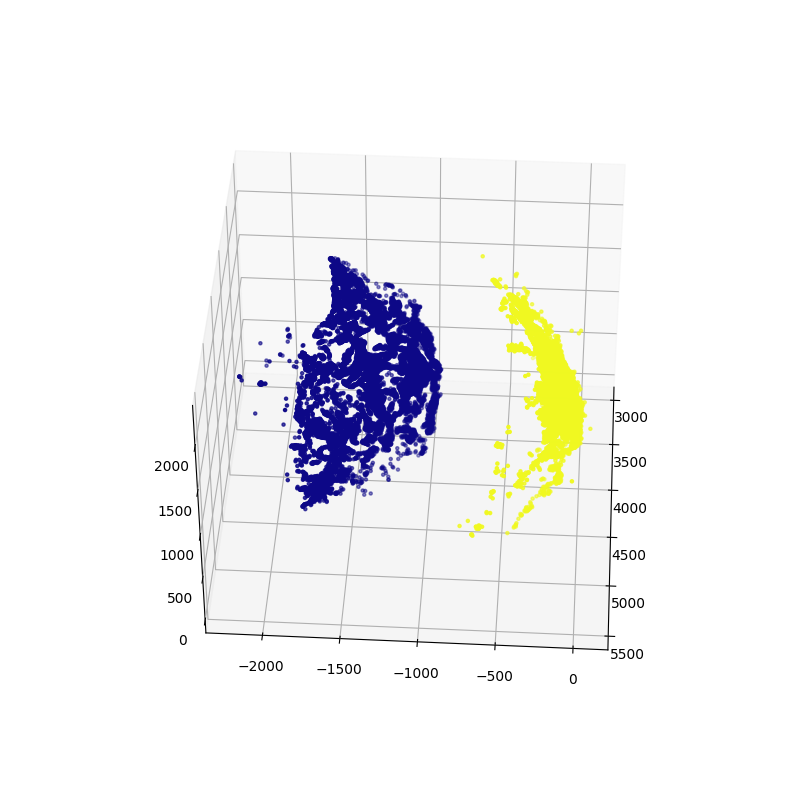

1.0308382155009643 -25.880083797424234 -25.105863760441878


<IPython.core.display.Javascript object>


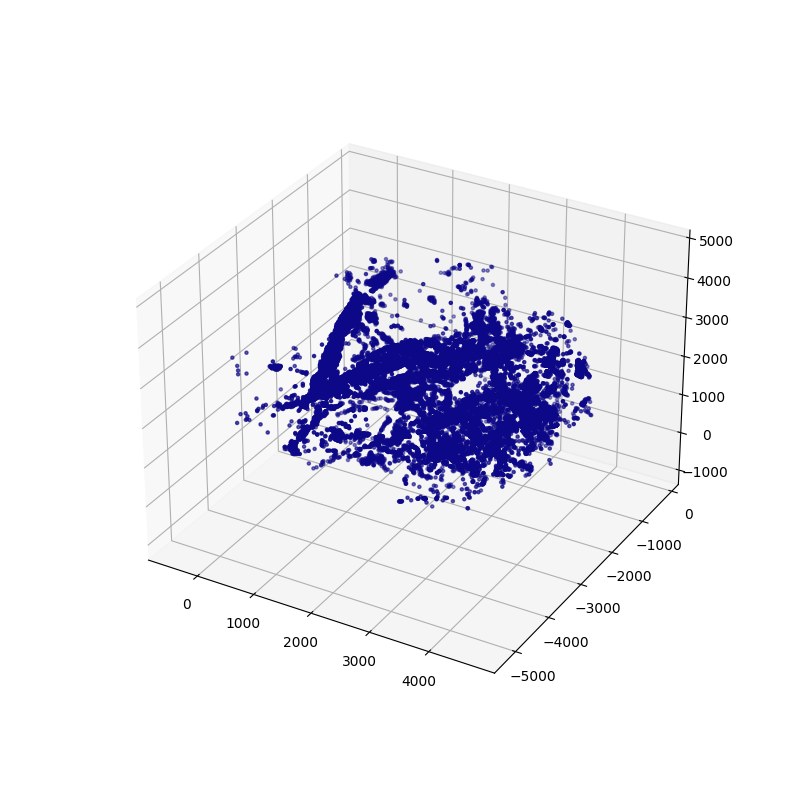

1.0568841445094996 -22.734894724681535 -21.511245904093688


<IPython.core.display.Javascript object>


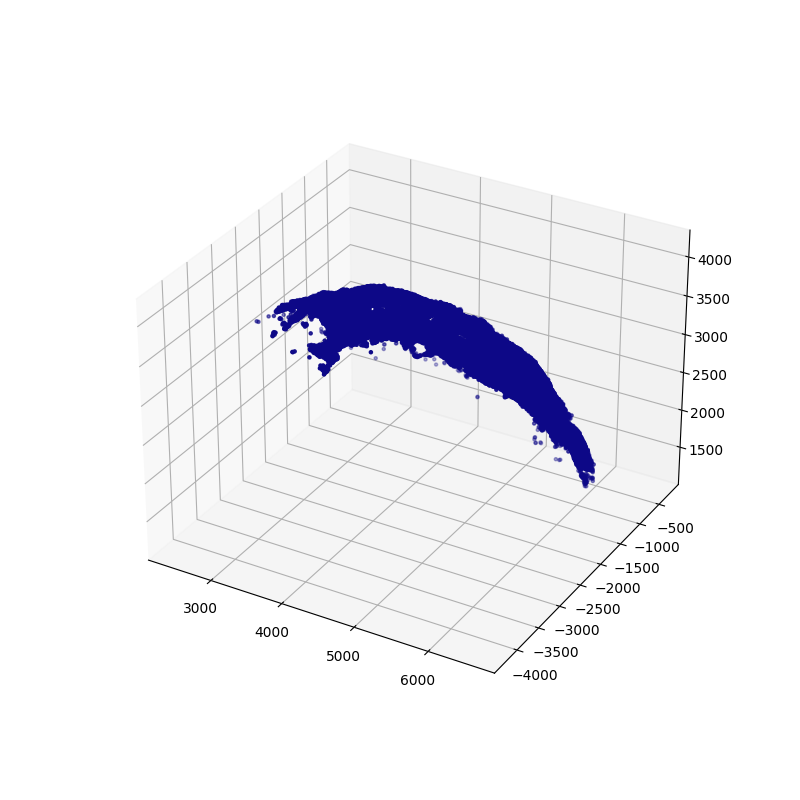

1.0687010598961861 -19.94197994981474 -18.660017003961716


<IPython.core.display.Javascript object>


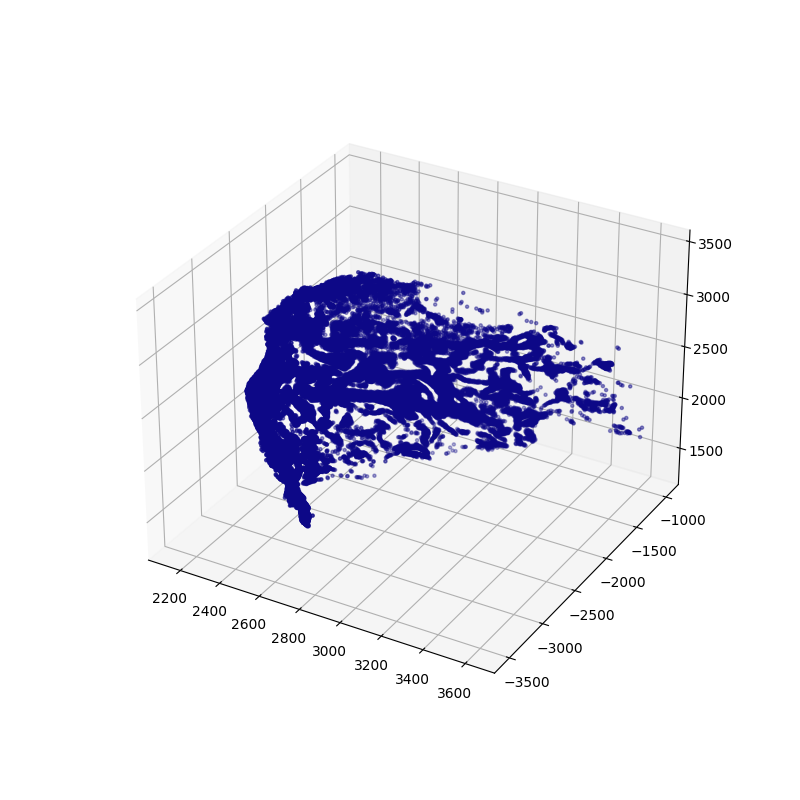

<ipython-input-23-3a4fdd65ebc6>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clusters = np.array(clusters)
<ipython-input-23-3a4fdd65ebc6>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels = np.array(labels)


In [23]:
clusters = []
labels = []
elbo_rat = []

for val in values.copy():
    plot_dat = virgo_cluster.cluster[virgo_cluster.cluster_labels == val]
    plot_y = virgo_cluster.cluster_labels[virgo_cluster.cluster_labels == val]
    
    model = GaussianMixture(n_components=1)
    model.fit(plot_dat)
    m1 = model.lower_bound_
    
    model = GaussianMixture(n_components=2)
    model.fit(plot_dat)
    m2 = model.lower_bound_

    print(m1 / m2, m1, m2)
    elbo_rat.append(m1 / m2)
    
    if (m1 / m2) < 1.075:
        clusters.append(plot_dat)
        labels.append(plot_y)
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_y, marker=".", cmap="plasma")
        plt.show()

    else:
        
        plot_pred_y = model.predict(plot_dat)
        new_label = len(values)
        
        clusters.append(plot_dat[plot_pred_y==0])
        labels.append(plot_y[plot_pred_y==0])
        
        clusters.append(plot_dat[plot_pred_y==1])
        plot_y[plot_pred_y==1] = new_label
        labels.append(plot_y[plot_pred_y==1])
        values.append(new_label)
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_pred_y, marker=".", cmap="plasma")
        plt.show()

clusters = np.array(clusters)
labels = np.array(labels)

In [24]:
for ind, clust in enumerate(clusters):
    print(labels[ind].shape[0])
    
    if ind == 0:
        all_clusters = np.array(clust)
        all_labs = np.array(labels[ind])
    else:
        all_clusters = np.concatenate([all_clusters, clust])
        all_labs = np.concatenate([all_labs, labels[ind]])


virgo_cluster.cluster = all_clusters
virgo_cluster.cluster_labels = all_labs

40765
129169
36691
89600
11577
39427
46418
45648
27992
7918
60882
91859
66818


<IPython.core.display.Javascript object>


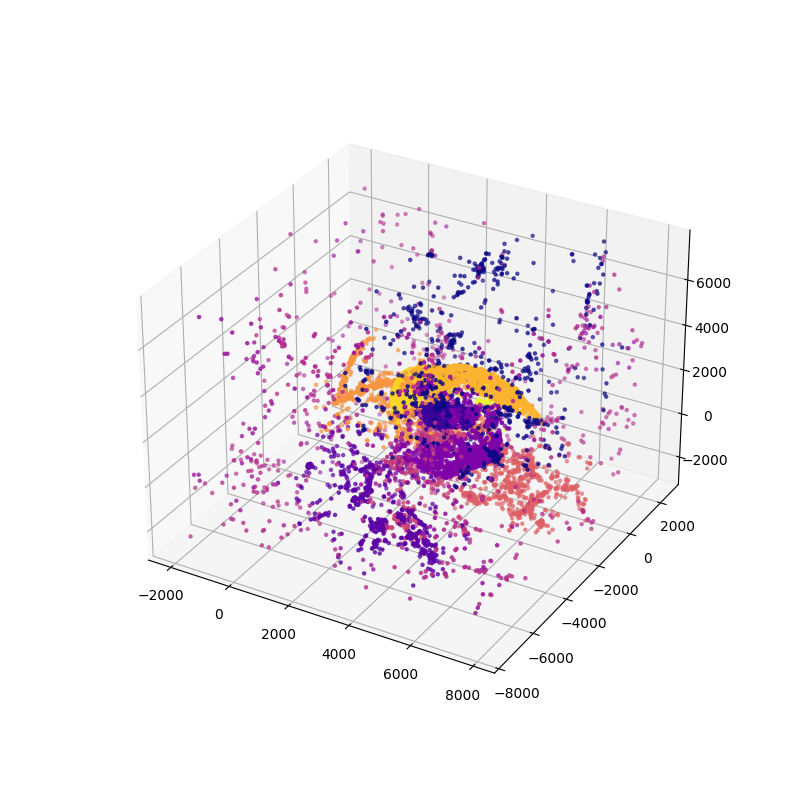

In [32]:
virgo_cluster.plot_cluster(n_step=50)

<IPython.core.display.Javascript object>


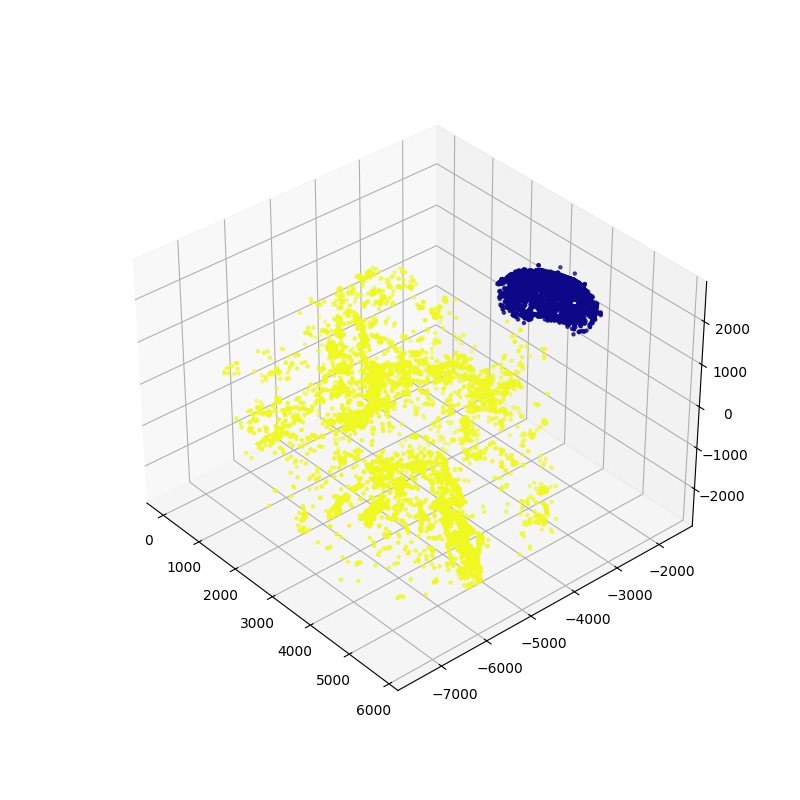

In [33]:
virgo_cluster.plot_cluster(n_step=4, cluster_ind=[2, 1])